In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler


In [ ]:

from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])

print("Shape:", df.shape)
df.head()

Saving cleaned_customer_churn (6).csv to cleaned_customer_churn (6) (2).csv
Shape: (250, 23)


,Date,TotalLogin,TotalWatchTime,HouseholdSize,IsAutoRenew,Churned,SubscriptionPlan_Premium,SubscriptionPlan_Standard,AgeGroup_26-35,AgeGroup_36-50,...,ContentPreference_TV Shows,Location_East,Location_North,Location_South,Location_West,PrimaryDevice_Smart TV,PrimaryDevice_Tablet,PrimaryDevice_Web Browser,BillingCycle_Monthly,BillingCycle_Quarterly
0,2025-05-22,-1.537392,-1.127486,-0.111223,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
1,2025-06-30,-0.404249,-0.900591,-1.700127,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
2,2025-06-30,-0.687535,-1.005982,0.683229,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
3,2025-06-30,1.153823,0.707707,1.477680,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
4,2025-06-30,0.941359,1.924927,1.477680,1,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [ ]:

df["CustomerValue"] = df["TotalLogin"]*0.4 + df["TotalWatchTime"]*0.6

X = df.drop(columns=["Churned", "Date"])
y = df["Churned"]

X = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:

model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94        41
           1       0.67      0.89      0.76         9

    accuracy                           0.90        50
   macro avg       0.82      0.90      0.85        50
weighted avg       0.92      0.90      0.91        50

ROC-AUC Score: 0.978319783197832


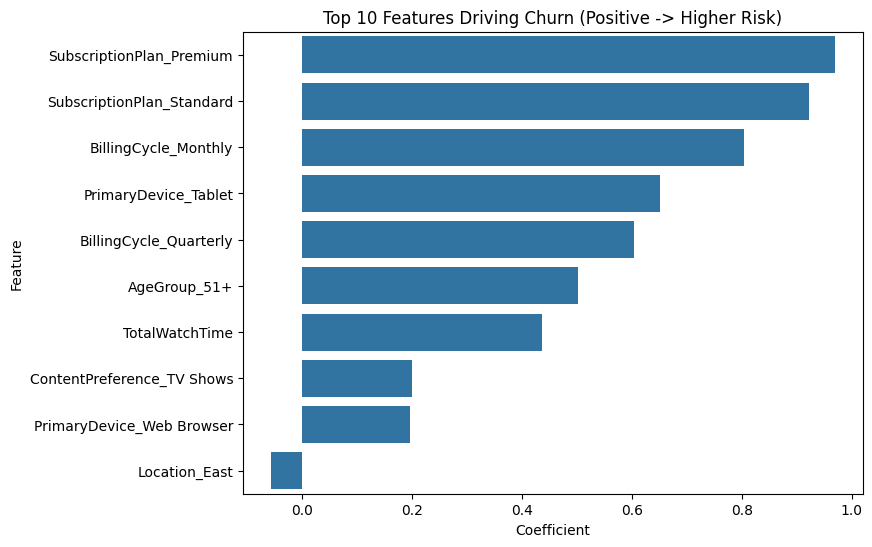

In [ ]:
importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="Coefficient", y="Feature", data=importance.head(10))
plt.title("Top 10 Features Driving Churn (Positive -> Higher Risk)")
plt.show()


 Customer Segmentation:

                  Segment  Customers  Churned  AvgValue
0  High Risk - High Value         10        8  0.821700
1   High Risk - Low Value         40       36 -1.215275
2   Low Risk - High Value        115        0  0.832209
3    Low Risk - Low Value         85        1 -0.650706


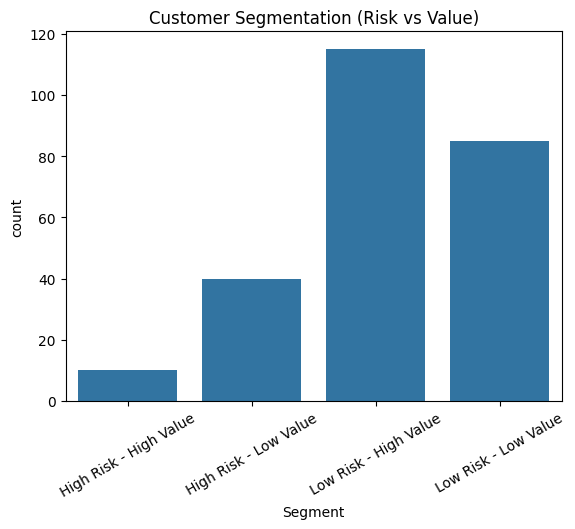

In [ ]:

df["ChurnRisk"] = model.predict_proba(X_scaled)[:,1]

risk_threshold = 0.5
value_threshold = df["CustomerValue"].median()

df["RiskSegment"] = np.where(df["ChurnRisk"] > risk_threshold, "High Risk", "Low Risk")
df["ValueSegment"] = np.where(df["CustomerValue"] > value_threshold, "High Value", "Low Value")

df["Segment"] = df["RiskSegment"] + " - " + df["ValueSegment"]

segment_summary = df.groupby("Segment").agg(
    Customers=("Churned", "count"),
    Churned=("Churned", "sum"),
    AvgValue=("CustomerValue", "mean")
).reset_index()

print("\n Customer Segmentation:\n")
print(segment_summary)

sns.countplot(data=df, x="Segment", order=segment_summary["Segment"])
plt.title("Customer Segmentation (Risk vs Value)")
plt.xticks(rotation=30)
plt.show()

In [ ]:

segment_stats = df.groupby("Segment").agg(
    Customers=("Churned", "count"),
    AvgValue=("CustomerValue", "mean"),
    AvgRisk=("ChurnRisk", "mean")
).reset_index()

print("\n Current Segment Stats:\n")
print(segment_stats)

impact_segment = "High Risk - High Value"
reduction_factor = 0.10

seg_df = df[df["Segment"] == impact_segment].copy()
current_expected_loss = (seg_df["ChurnRisk"] * seg_df["CustomerValue"]).sum()

seg_df["ChurnRisk_AfterCampaign"] = seg_df["ChurnRisk"] * (1 - reduction_factor)
new_expected_loss = (seg_df["ChurnRisk_AfterCampaign"] * seg_df["CustomerValue"]).sum()

impact_value = current_expected_loss - new_expected_loss

print(f"\n Estimated impact of campaign on {impact_segment}:")
print(f" Expected loss before: {current_expected_loss:,.0f}")
print(f" Expected loss after: {new_expected_loss:,.0f}")
print(f" Value saved: {impact_value:,.0f}")



 Current Segment Stats:

                  Segment  Customers  AvgValue   AvgRisk
0  High Risk - High Value         10  0.821700  0.839488
1   High Risk - Low Value         40 -1.215275  0.927541
2   Low Risk - High Value        115  0.832209  0.036867
3    Low Risk - Low Value         85 -0.650706  0.077286

 Estimated impact of campaign on High Risk - High Value:
 Expected loss before: 7
 Expected loss after: 6
 Value saved: 1


 Overall Churn Rate: 18.00%
 Average Customer Value: -0.00


/tmp/ipython-input-2211829083.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Segment", order=df["Segment"].value_counts().index, palette="Set2")


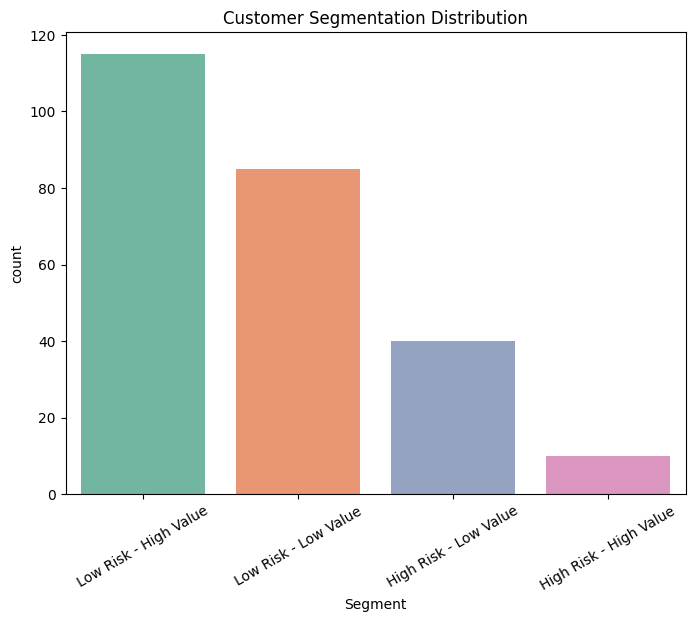

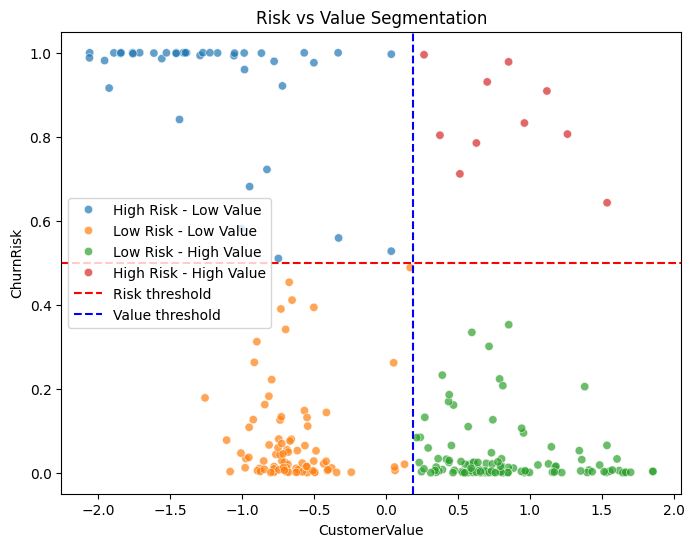

In [ ]:


churn_rate = df["Churned"].mean() * 100
avg_value = df["CustomerValue"].mean()

print(f" Overall Churn Rate: {churn_rate:.2f}%")
print(f" Average Customer Value: {avg_value:.2f}")

plt.figure(figsize=(8,6))
sns.countplot(data=df, x="Segment", order=df["Segment"].value_counts().index, palette="Set2")
plt.title("Customer Segmentation Distribution")
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="CustomerValue", y="ChurnRisk", hue="Segment", alpha=0.7)
plt.axhline(0.5, color="red", linestyle="--", label="Risk threshold")
plt.axvline(df["CustomerValue"].median(), color="blue", linestyle="--", label="Value threshold")
plt.legend()
plt.title("Risk vs Value Segmentation")
plt.show()
